In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


### DAY 2: 시간대별 전력 부하 구조 분석

**목적**
- 서울시 전력 수요가 하루 중 어떤 시간대에 집중되는지 확인

**주요 작업**
- USE_HM → hour 변환
- 시간대별 평균 전력 사용량 계산

**산출물**
- 서울시 평균 일간 전력 부하 곡선

In [ ]:
'''
DAY 2 목표:
시간대(hour) 기준으로 전력 부하의 분포와 피크 구조를 파악한다
(태양광/덕커브/요일/계절 확장은 오늘 하지 않는다)
'''

In [2]:
# 1. 경로 세팅 + DAY 1 결과 로드

# 1) 현재 위치
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

# 저장 폴더
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

# 저장 옵션
SAVE_KWARGS = dict(
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.1
)

# 2) 원본 파일 경로
RAW_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"

# 3) 파일 존재 확인
if not RAW_FILE.exists():
    raise FileNotFoundError(f"CSV 파일을 찾지 못함: {RAW_FILE}")

print("NOTEBOOK_DIR =", NOTEBOOK_DIR)
print("PROJECT_ROOT =", PROJECT_ROOT)
print("DATA_DIR =", DATA_DIR)
print("RAW_FILE =", RAW_FILE)

# 4) 인코딩 이슈 대비 로드
encodings_to_try = ["utf-8-sig", "cp949", "euc-kr"]

df_raw = None
last_error = None

for enc in encodings_to_try:
    try:
        df_raw = pd.read_csv(RAW_FILE, encoding = enc)
        print(f"로드 성공 (encoding = {enc})")
        break
    except Exception as e:
        last_error = e

if df_raw is None:
    raise RuntimeError(f"CSV 로드 실패, 마지막 에러: {last_error}")

print("행 / 열 =", df_raw.shape)
df_raw.head()

NOTEBOOK_DIR = e:\Portfolio_ver1\seoul_pv_load_analysis\notebooks
PROJECT_ROOT = e:\Portfolio_ver1\seoul_pv_load_analysis
DATA_DIR = e:\Portfolio_ver1\seoul_pv_load_analysis\data
RAW_FILE = e:\Portfolio_ver1\seoul_pv_load_analysis\data\법정동별시간별전력사용량.csv
로드 성공 (encoding = utf-8-sig)
행 / 열 = (9754804, 5)


,SIGUNGU_CD,BJDONG_CD,USE_YM,USE_HM,FDRCT_VLD_KWH
0,11650,10700,20220628,100,10782.0565
1,11650,10800,20220628,100,11394.8635
2,11650,10900,20220628,100,7273.9620
3,11740,10300,20220628,100,11008.8110
4,11710,11300,20220628,100,2905.1120


In [3]:
# 2. DAY 2 분석용 최소 테이블(df_base) 재구성
df = df_raw.copy()

# 0) 타입 정리
df["USE_YM"] = pd.to_numeric(df["USE_YM"], errors="coerce").astype("Int64")
df["USE_HM"] = pd.to_numeric(df["USE_HM"], errors="coerce").astype("Int64")

# 1) 날짜 변환 (USE_YM)
# - 8자리면 YYYYMMDD
# - 6자리면 YYYYMM (일자는 1일로 고정)
ym_str = df["USE_YM"].astype("string")
len_ym = ym_str.str.len()

df["date"] = pd.NaT
mask8 = len_ym == 8
mask6 = len_ym == 6

df.loc[mask8, "date"] = pd.to_datetime(ym_str[mask8], format="%Y%m%d", errors="coerce")
df.loc[mask6, "date"] = pd.to_datetime(ym_str[mask6] + "01", format="%Y%m%d", errors="coerce")

# 2) 시간(hour) 추출
# - USE_HM이 1~24면 hour = USE_HM - 1
# - USE_HM이 100~2400이면 hour = USE_HM//100 - 1
hm = df["USE_HM"]

df["hour"] = pd.Series(pd.NA, index=df.index, dtype="Int64")
mask_1to24 = hm.between(1, 24, inclusive="both")
mask_100to2400 = hm.between(100, 2400, inclusive="both")

df.loc[mask_1to24, "hour"] = (hm[mask_1to24] - 1).astype("Int64")
df.loc[mask_100to2400, "hour"] = (hm[mask_100to2400] // 100 - 1).astype("Int64")

# hour 유효범위 밖은 결측 처리
df.loc[~df["hour"].between(0, 23, inclusive="both"), "hour"] = pd.NA

# 3) datetime 생성
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit="h")

# 4) value 생성
df["value"] = pd.to_numeric(
    df["FDRCT_VLD_KWH"].astype(str).str.replace(",", "", regex=False),
    errors="coerce"
)

# 5) 최소 테이블
df_base = df[["datetime", "hour", "value"]].copy()

# 6) 품질 체크
print("df_base 크기 =", df_base.shape)
print("date 결측률(%) =", df["date"].isna().mean() * 100)
print("hour 범위 =", df_base["hour"].min(), "~", df_base["hour"].max())
print("hour 결측률(%) =", df_base["hour"].isna().mean() * 100)
print("value 결측률(%) =", df_base["value"].isna().mean() * 100)
print("datetime 결측률(%) =", df_base["datetime"].isna().mean() * 100)


df_base.head()

df_base 크기 = (9754804, 3)
date 결측률(%) = 0.0
hour 범위 = 0 ~ 23
hour 결측률(%) = 0.0
value 결측률(%) = 0.0
datetime 결측률(%) = 0.0


,datetime,hour,value
0,2022-06-28,0,10782.0565
1,2022-06-28,0,11394.8635
2,2022-06-28,0,7273.9620
3,2022-06-28,0,11008.8110
4,2022-06-28,0,2905.1120


In [4]:
# 3. 시간대별 평균 부하(대표 패턴) 계산

# 1) hour (0 ~ 23) 기준으로 평균 전력 사용량 계산
hourly_mean = (df_base.groupby("hour", as_index = False)["value"].mean().sort_values("hour"))

# 2) 혹시 누락된 hour가 있으면 0 ~ 23을 채우기
all_hours = pd.DataFrame({"hour": np.arange(0, 24)})
hourly_mean = all_hours.merge(hourly_mean, on = "hour", how = "left")

print("시간대별 평균 테이블(상위 10행):")
hourly_mean.head(10)

시간대별 평균 테이블(상위 10행):


,hour,value
0,0,4828.966546
1,1,4436.061656
2,2,4301.931715
3,3,4069.172541
4,4,4467.956892
5,5,4570.492076
6,6,5000.093613
7,7,5677.409920
8,8,6575.992184
9,9,7246.801206


In [5]:
# 4. 피크 시간대 TOP3 확인

# value가 큰 순으로 TOP 3 시간대 확인
top3 = hourly_mean.sort_values("value", ascending = False).head(3)

print("피크 시간대 TOP 3 (hour, mean_value):")
display(top3)

# 피크 hour 하나도 뽑아두기
peak_hour = int(top3.iloc[0]["hour"])
print("최대 피크 시간대(대표) =", peak_hour, "시")

피크 시간대 TOP 3 (hour, mean_value):


,hour,value
13,13,7647.383917
12,12,7556.557942
11,11,7545.208877


최대 피크 시간대(대표) = 13 시


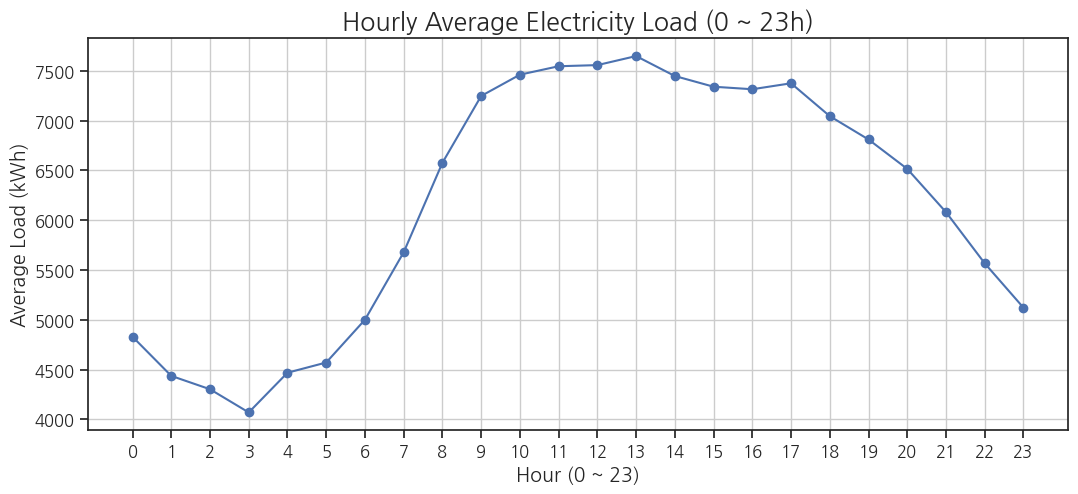

In [6]:
# 부하 곡선(그래프 1개) 생성

# 1) 그래프 그리기
plt.figure(figsize = (10, 4))
plt.plot(hourly_mean["hour"], hourly_mean["value"], marker = "o")

plt.title("Hourly Average Electricity Load (0 ~ 23h)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Average Load (kWh)")
plt.xticks(np.arange(0, 24, 1))
plt.savefig(FIG_DIR / "DAY2_hourly_average_electricity_load.png", **SAVE_KWARGS)
plt.grid(True)
plt.show()

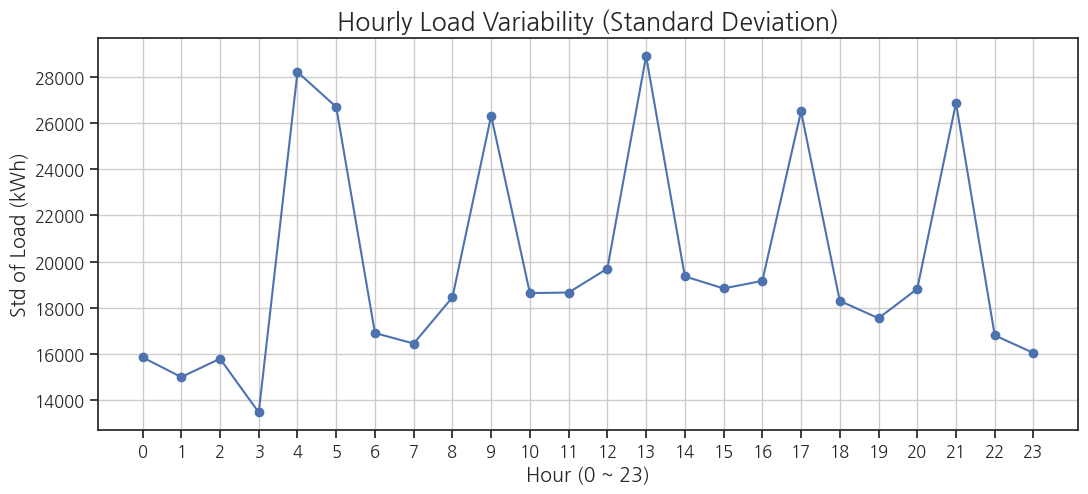

In [7]:
# 6. 변동성 / 분포 확인 - "평균만 보면 위험하지 않나" 방어용

# 시간대별 표준편차(변동성)도 같이 본다.
hourly_std = (df_base.groupby("hour", as_index = False)["value"].std().sort_values("hour"))
hourly_std = all_hours.merge(hourly_std, on = "hour", how = "left")

plt.figure(figsize = (10, 4))
plt.plot(hourly_std["hour"], hourly_std["value"], marker = "o")

plt.title("Hourly Load Variability (Standard Deviation)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Std of Load (kWh)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.savefig(FIG_DIR / "DAY2_hourly_load_variability.png", **SAVE_KWARGS)
plt.show()

In [8]:
# 7. DAY 2 Conclusion

print("===DAY 2 Conclusion===")
print(f"- 시간대(hour) 기준 평균 부하 곡선을 통해 전력 사용의 일중 분포를 확인")
print(f"- 대표 피크는 {peak_hour}시 전후에서 관측되며, 전력 사용이 특정 시간대에 집중하는 구조를 가진다.")
print("- 이 결과는 DAY 3의 태양광 이론 패턴과 비교하여 시간대 불일치를 해석하는 기준선으로 사용한다.")
print("- 특히 오후 후반 및 저녁 시간대에서는 부하 변동성 또한 크게 나타나, 단일 발전원 기반 대응의 한계를 시사한다.")

===DAY 2 Conclusion===
- 시간대(hour) 기준 평균 부하 곡선을 통해 전력 사용의 일중 분포를 확인
- 대표 피크는 13시 전후에서 관측되며, 전력 사용이 특정 시간대에 집중하는 구조를 가진다.
- 이 결과는 DAY 3의 태양광 이론 패턴과 비교하여 시간대 불일치를 해석하는 기준선으로 사용한다.
- 특히 오후 후반 및 저녁 시간대에서는 부하 변동성 또한 크게 나타나, 단일 발전원 기반 대응의 한계를 시사한다.


In [9]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'np', 'pd', 'shutil', 'datetime', 'plt', 'sns', 'Path', 'fm', 'rcParams', 'FONT_DIR', 'FONT_PATH', 'font_name', 'font_prop', '_i2', 'NOTEBOOK_DIR', 'PROJECT_ROOT', 'DATA_DIR', 'OUT_DIR', 'FIG_DIR', 'SAVE_KWARGS', 'RAW_FILE', 'encodings_to_try', 'df_raw', 'last_error', 'enc', '_2', '_i3', 'df', 'ym_str', 'len_ym', 'mask8', 'mask6', 'hm', 'mask_1to24', 'mask_100to2400', 'df_base', '_3', '_i4', 'hourly_mean', 'all_hours', '_4', '_i5', 'top3', 'peak_hour', '_i6', '_i7', 'hourly_std', '_i8', '_i9'])

In [10]:
# Day 2 output: hourly average load profile
day2_out = hourly_mean.copy()

# 컬럼명 정리 (value → load_mean 인 경우 대비)
if "value" in day2_out.columns:
    day2_out = day2_out.rename(columns={"value": "load_mean"})

day2_out.to_csv(
    OUT_DIR / "DAY2_hourly_load_profile.csv",
    index=False,
    encoding="utf-8-sig"
)

print("Saved: outputs/DAY2_hourly_load_profile.csv")
day2_out.head()

Saved: outputs/DAY2_hourly_load_profile.csv


,hour,load_mean
0,0,4828.966546
1,1,4436.061656
2,2,4301.931715
3,3,4069.172541
4,4,4467.956892


In [11]:
hourly_mean = (df.groupby("hour")["value"].mean().reindex(range(24)))
peak_hour = int(hourly_mean.idxmax())
peak_val = float(hourly_mean.max())
print(f"Peak Hour: {peak_hour}시")

Peak Hour: 13시


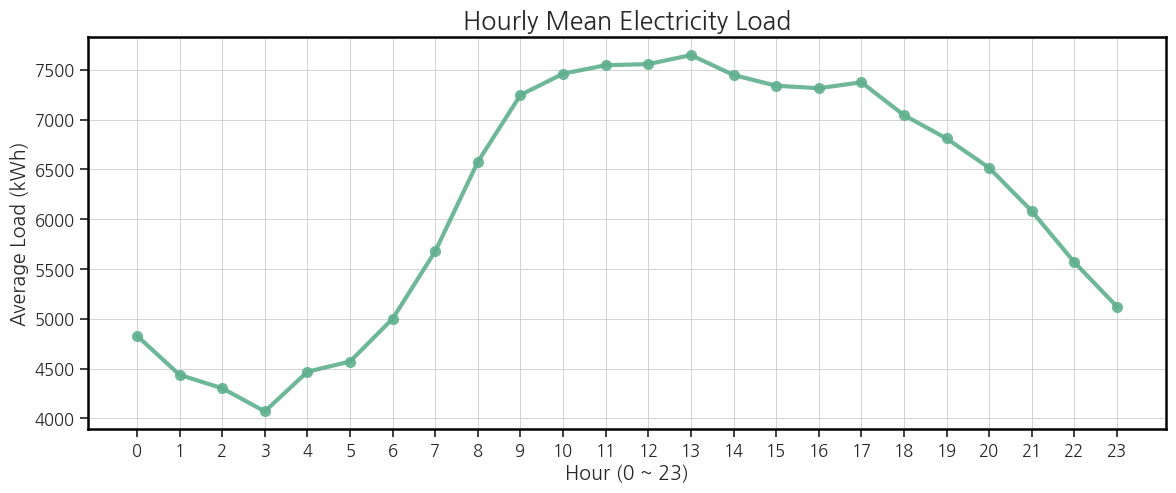

In [12]:
plt.figure(figsize=(11, 4))
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.8)
    spine.set_color("black")
ax.grid(True, linewidth=0.6, alpha=1)
plt.plot(hourly_mean.index, hourly_mean.values, marker = "o", linewidth=3, color="#5FAF8E", markersize=8, markeredgewidth=0, alpha = 0.9)
plt.title("Hourly Mean Electricity Load")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Average Load (kWh)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.savefig(FIG_DIR / "DAY2_hourly_mean_electicity_load.png", **SAVE_KWARGS)
plt.show()

In [13]:
hourly_profile = (
    df_base
    .dropna(subset=["hour", "value"])
    .groupby("hour")["value"]
    .mean()
    .reset_index()
)

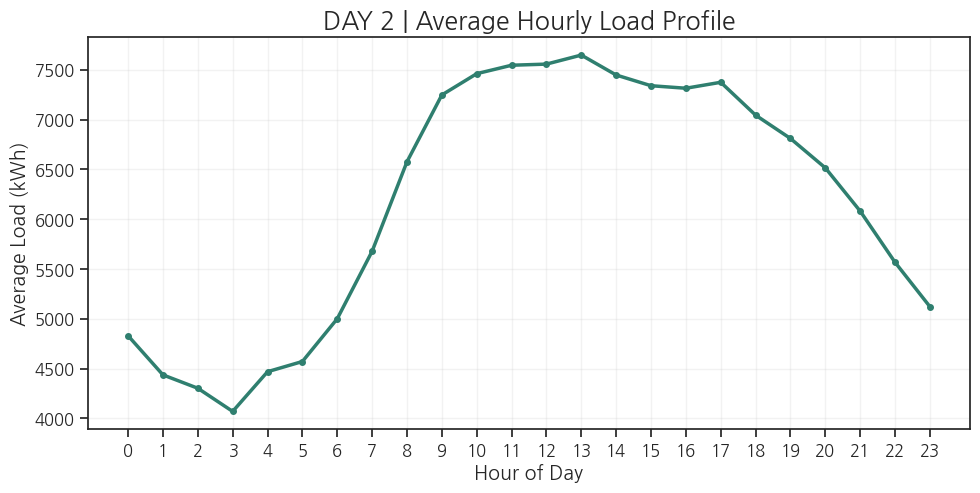

In [14]:
hourly_mean = (
    df_base.dropna(subset=["hour","value"])
    .groupby("hour")["value"]
    .mean()
    .reindex(range(24))
)

plt.figure(figsize=(9,4))

LINE_COLOR = "#2F7F6F"     # 진한 그린

plt.plot(
    hourly_mean.index,
    hourly_mean.values,
    color=LINE_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4
)

plt.xticks(range(0,24,1))
plt.xlabel("Hour of Day")
plt.ylabel("Average Load (kWh)")
plt.title("DAY 2 | Average Hourly Load Profile")
plt.grid(alpha=0.25)

plt.savefig(FIG_DIR / "DAY2_hourly_load_mean.png", **SAVE_KWARGS)
plt.show()

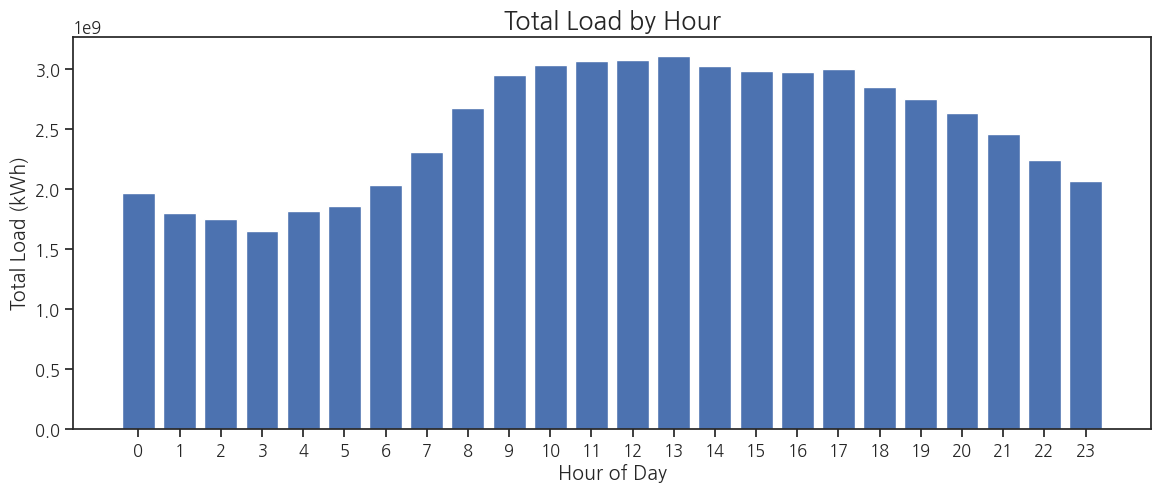

In [15]:
hourly_sum = (
    df_base
    .dropna(subset=["hour", "value"])
    .groupby("hour")["value"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(11, 4))
plt.bar(hourly_sum["hour"], hourly_sum["value"])
plt.xlabel("Hour of Day")
plt.ylabel("Total Load (kWh)")
plt.title("Total Load by Hour")
plt.xticks(range(0, 24))

plt.savefig(FIG_DIR / "Total_Load_by_Hour.png", **SAVE_KWARGS)
plt.show()

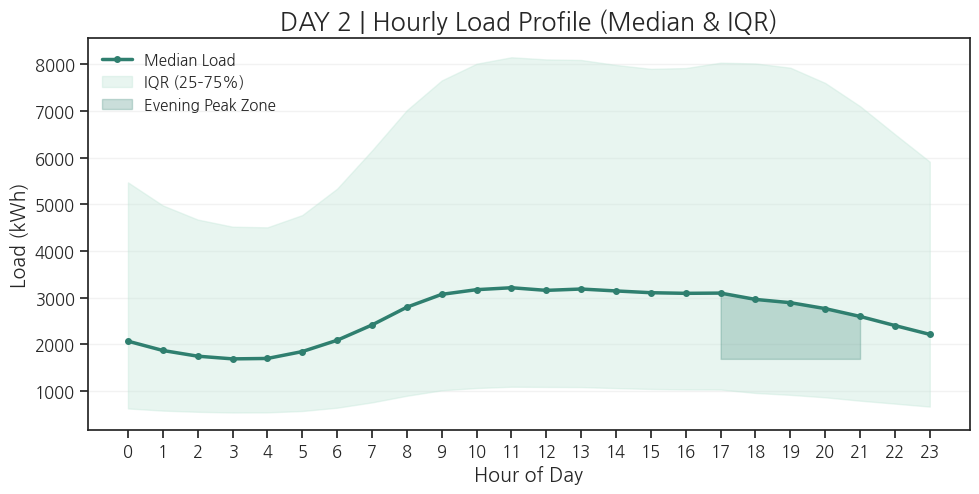

In [16]:
# 데이터 준비
q = (
    df_base.dropna(subset=["hour","value"])
    .groupby("hour")["value"]
    .quantile([0.25, 0.5, 0.75])
    .unstack()
    .reindex(range(24))
)

# 색상 (너가 쓰던 연한 그린 계열 기준)
LINE_COLOR = "#2F7F6F"     # 진한 그린
BAND_COLOR = "#BFE5D6"     # 연한 그린

plt.figure(figsize=(9, 4))

# IQR 밴드
plt.fill_between(
    q.index,
    q[0.25],
    q[0.75],
    color=BAND_COLOR,
    alpha=0.35,
    label="IQR (25–75%)"
)

# 중앙값 선
plt.plot(
    q.index,
    q[0.5],
    color=LINE_COLOR,
    linewidth=2.5,
    marker="o",
    markersize=4,
    label="Median Load"
)

# 피크 시간대 마스크 (예: 17~21시)
peak_mask = (q.index >= 17) & (q.index <= 21)

# 중앙값 라인 아래 음영
baseline = q[0.5].min()

plt.fill_between(
    q.index,
    q[0.5],
    baseline,
    where=peak_mask,
    color=LINE_COLOR,
    alpha=0.25,
    label="Evening Peak Zone"
)

# y축 여백 추가
plt.ylim(top=q[0.75].max() * 1.05)


# 축 / 제목
plt.xticks(range(0, 24, 1))
plt.xlabel("Hour of Day")
plt.ylabel("Load (kWh)")
plt.title("DAY 2 | Hourly Load Profile (Median & IQR)")

# 그리드 (은은하게)
plt.grid(axis="y", alpha=0.25)

# 범례
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]  # Median → IQR → Peak

plt.legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    frameon=False
)

# 저장
plt.savefig(FIG_DIR / "DAY2_hourly_load_median_iqr.png", **SAVE_KWARGS)
plt.show()